In [1]:
## Modules nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path
import glob

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping, TensorBoard

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

In [3]:
test = pd.read_csv('../../data/test_set.csv')

In [4]:
plt.imread(test.img_path[0])

FileNotFoundError: [Errno 2] No such file or directory: '.\\LY\\LY_925823.jpg'

In [3]:
#get path to data/main_dir
path_name = '../../data/PBC_dataset_normal_DIB'
selected_label = ['MY', 'SNE', 'MMY', 'BNE', 'IG', 'PMY', 'NEUTROPHIL']
df_train, df_valid, df_test = leuko.load_df_tf_dir(path_name, selection_list=selected_label)

In [4]:
# Params
x_col = 'img_paths'
y_col = 'label'
batch_size = 32
img_size  = (224, 224) #needed for EfficientNet

In [6]:
# Augmentation, no normalisation EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True,
                                    zoom_range=0.6,
                                    brightness_range=[0,2])

valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Batchs, redimensionnement, chargement des images
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = x_col, 
                                                   y_col = y_col,
                                                   target_size = img_size, 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size, 
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = x_col, 
                                                     y_col = y_col,
                                                     target_size = img_size, 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = x_col, 
                                                 y_col = y_col,
                                                 target_size = img_size,
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = True)

Found 4381 validated image filenames belonging to 7 classes.
Found 598 validated image filenames belonging to 7 classes.
Found 1245 validated image filenames belonging to 7 classes.


In [7]:
# Correspondance indices/labels (ordre alphanumérique):
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

label_map = training_set.class_indices

Train : {'BNE': 0, 'IG': 1, 'MMY': 2, 'MY': 3, 'NEUTROPHIL': 4, 'PMY': 5, 'SNE': 6}
Valid : {'BNE': 0, 'IG': 1, 'MMY': 2, 'MY': 3, 'NEUTROPHIL': 4, 'PMY': 5, 'SNE': 6}
Test  : {'BNE': 0, 'IG': 1, 'MMY': 2, 'MY': 3, 'NEUTROPHIL': 4, 'PMY': 5, 'SNE': 6}


In [9]:
!mkdir tf_log/effNet_subclasses_NE

In [8]:
Path('tf_log/effNet_subclasses')

'../../data/PBC_dataset_normal_DIB'

In [10]:
# Callbacks :

TON = TerminateOnNaN()

save_model = ModelCheckpoint(filepath = 'tf_log/effNet_subclasses_NE', 
                             monitor = 'val_loss', 
                             save_best_only = True,
                             save_weights_only = True,
                             save_freq = 'epoch')

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, 
                               patience = 3, 
                               verbose = 1, 
                               mode = 'min')

early_stopping = EarlyStopping(monitor = "val_loss", 
                               patience = 6, 
                               mode = 'min',
                               restore_best_weights = True)

# %load_ext tensorboard
log_dir = Path('./tf_log/effNet_subclasses_NE')
tensorboard = TensorBoard(log_dir = log_dir)


In [14]:
## Modèle : EfficientNet pour transfer learning

base_model = EfficientNetB3(include_top = False,
                            weights = 'imagenet',
                            input_shape = (224,224,3),
                            pooling = 'avg')

# for layer in base_model.layers:
#     layer.trainable = False

base_model.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(layers.Dense(units = 1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 7, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 3591      
Total params: 12,885,814
Trainable params: 2,102,279
Non-trainable params: 10,783,535
__________________________________

In [15]:
# Compilation
model.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [16]:
epochs = 200
history = model.fit(training_set, 
                    epochs = epochs, 
                    validation_data = validation_set, 
                    callbacks = [save_model, control_lr, TON, early_stopping])

Epoch 1/200
137/137 [==============================] - 249s 2s/step - loss: 1.2232 - accuracy: 0.4389 - val_loss: 0.9415 - val_accuracy: 0.5970
Epoch 2/200
137/137 [==============================] - 236s 2s/step - loss: 1.0180 - accuracy: 0.5325 - val_loss: 0.9147 - val_accuracy: 0.5251
Epoch 3/200
137/137 [==============================] - 231s 2s/step - loss: 0.9762 - accuracy: 0.5398 - val_loss: 0.8548 - val_accuracy: 0.6405
Epoch 4/200
137/137 [==============================] - 240s 2s/step - loss: 0.9420 - accuracy: 0.5668 - val_loss: 0.8267 - val_accuracy: 0.6171
Epoch 5/200
137/137 [==============================] - 348s 3s/step - loss: 0.9258 - accuracy: 0.5741 - val_loss: 0.8039 - val_accuracy: 0.6154
Epoch 6/200
137/137 [==============================] - 335s 2s/step - loss: 0.9103 - accuracy: 0.5743 - val_loss: 0.7846 - val_accuracy: 0.6538
Epoch 7/200
137/137 [==============================] - 294s 2s/step - loss: 0.8864 - accuracy: 0.5905 - val_loss: 0.7915 - val_accuracy:

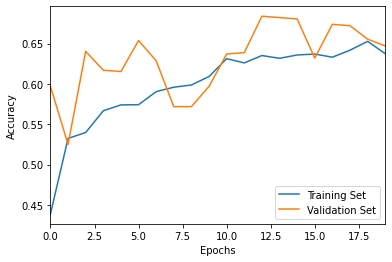

In [20]:
# Courbe d'entrainement :
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,19])
# plt.ylim([0.5,1])
plt.legend()
plt.show()

In [21]:
# Évaluation sur les données test :

model.evaluate(testing_set)

39/39 [==============================] - 52s 1s/step - loss: 0.6739 - accuracy: 0.7100


[0.6738611459732056, 0.7100401520729065]

PosixPath('tf/log')

In [22]:
!mkdir tf_log